<a href="https://colab.research.google.com/github/yudhishtergurjar/Resume-Ranking-System/blob/main/resume_rank2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install PyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 7.6 MB/s eta 0:00:00


📂 Resume folder exists: data_resume

📊 Resume Ranking Results:
            Resume_File  ATS_Score  Similarity_Score  Final_Score     Missing_Skills                                     Recommendation
      Ritik_Resume .pdf  71.818182         41.299026    50.454773              cloud           🟡 Medium match - minor upskilling needed
       kabir_resume.pdf  71.818182         31.208080    43.391109              cloud 🔴 Low match - significant skill development needed
Lakshay_resume4.pdf.pdf  10.000000          9.367941     9.557558 cloud, python, nlp 🔴 Low match - significant skill development needed


/tmp/ipython-input-4127534825.py:193: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Final_Score', y='Resume_File', data=ranking_results, palette='viridis')


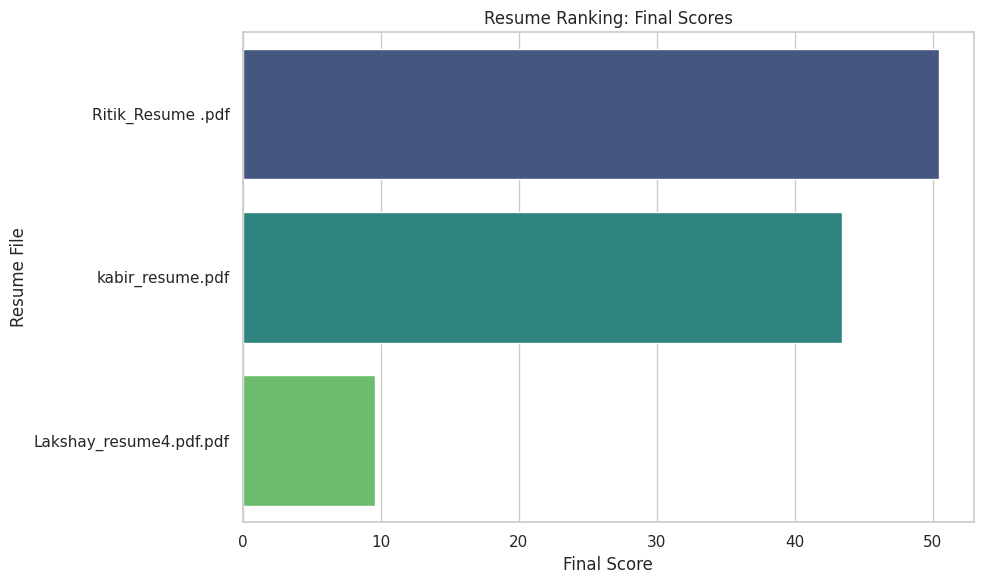

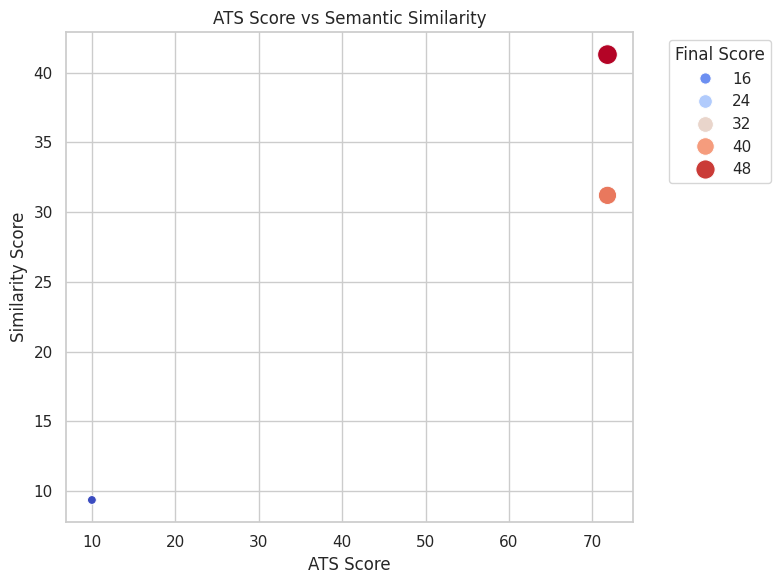


📈 Descriptive Statistics:
       ATS_Score  Similarity_Score  Final_Score
count   3.000000          3.000000     3.000000
mean   51.212121         27.291685    34.467815
std    35.690744         16.321833    21.860111
min    10.000000          9.367941     9.557558
25%    40.909091         20.288011    26.474335
50%    71.818182         31.208080    43.391109
75%    71.818182         36.253553    46.922941
max    71.818182         41.299026    50.454773


In [ ]:
# ===========================
# AI-Based Resume Ranking System
# ===========================

import os
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import PyPDF2
import spacy
from pathlib import Path
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import MinMaxScaler

# ---------------------------
# Load NLP and Transformer Models
# ---------------------------
nlp = spacy.load('en_core_web_sm')
model = SentenceTransformer('all-MiniLM-L6-v2')

# ---------------------------
# PDF Text Extraction
# ---------------------------
def extract_text_from_pdf(pdf_path):
    text = ''
    try:
        with open(pdf_path, 'rb') as file:
            reader = PyPDF2.PdfReader(file)
            for page in reader.pages:
                page_text = page.extract_text()
                if page_text:
                    text += page_text
    except Exception as e:
        print(f"Error extracting text from {pdf_path}: {e}")
        return None # Return None if extraction fails
    return text

# ---------------------------
# Text Preprocessing
# ---------------------------
def preprocess_text(text):
    doc = nlp(text.lower())
    tokens = [token.lemma_ for token in doc if not token.is_stop and token.is_alpha]
    return ' '.join(tokens)

# ---------------------------
# Extract Sections from Resume
# ---------------------------
def extract_sections(text):
    sections = {}
    patterns = {
        'education': r'(education|qualifications)[\s\S]*?(?=\n[A-Z][a-z]+|$)',
        'experience': r'(experience|employment|work history)[\s\S]*?(?=\n[A-Z][a-z]+|$)',
        'skills': r'(skills|expertise|abilities)[\s\S]*?(?=\n[A-Z][a-z]+|$)'
    }
    for key, pattern in patterns.items():
        match = re.search(pattern, text, re.IGNORECASE)
        sections[key] = match.group(0) if match else ''
    return sections

# ---------------------------
# ATS Score Calculation
# ---------------------------
def ats_score(resume, job_description):
    jd_tokens = set(job_description.split())
    resume_tokens = set(resume.split())
    keyword_overlap = len(jd_tokens.intersection(resume_tokens)) / max(len(jd_tokens), 1)

    sections = extract_sections(resume)
    section_score = sum([1 for sec in sections.values() if sec]) / len(sections)

    formatting_score = 1.0 if 200 < len(resume.split()) < 3000 else 0.5

    ats = 0.5 * keyword_overlap + 0.3 * section_score + 0.2 * formatting_score
    return ats * 100

# ---------------------------
# Semantic Similarity (using Transformer)
# ---------------------------
def semantic_similarity(resume, job_description):
    resume_emb = model.encode([resume])[0]
    jd_emb = model.encode([job_description])[0]
    sim = np.dot(resume_emb, jd_emb) / (np.linalg.norm(resume_emb) * np.linalg.norm(jd_emb))
    return sim

# ---------------------------
# Skill Extraction
# ---------------------------
def extract_skills(text, common_skills=None):
    if common_skills is None:
        common_skills = [
            "python", "tensorflow", "keras", "sklearn", "sql",
            "deep learning", "tableau", "nlp", "gcp", "aws", "pandas", "numpy",
            "data visualization", "cloud", "machine learning"
        ]
    text = text.lower()
    found_skills = set()
    for skill in common_skills:
        if skill in text:
            found_skills.add(skill)
    return found_skills

# ---------------------------
# Missing Skills Detection
# ---------------------------
def get_missing_skills(resume_text, job_desc_text):
    jd_skills = extract_skills(job_desc_text)
    resume_skills = extract_skills(resume_text)
    return jd_skills - resume_skills

# ---------------------------
# Recommendation Label
# ---------------------------
def recommend_label(final_score, missing_count):
    if final_score > 70 and missing_count == 0:
        return "🟢 High match - ready for interview"
    elif final_score > 50:
        return "🟡 Medium match - minor upskilling needed"
    else:
        return "🔴 Low match - significant skill development needed"

# ---------------------------
# Rank Resumes
# ---------------------------
def rank_resumes(resume_files, job_description_text, alpha=0.3, beta=0.7):
    results = []
    job_description = preprocess_text(job_description_text)

    if not resume_files:
        print("No PDF files found in the specified directory.")
        return pd.DataFrame() # Return empty DataFrame if no files are found

    for pdf in resume_files:
        raw_resume = extract_text_from_pdf(pdf)
        if raw_resume is None:
            continue # Skip if text extraction failed

        resume = preprocess_text(raw_resume)
        ats = ats_score(resume, job_description)
        sim = semantic_similarity(resume, job_description)
        final_score = alpha * ats + beta * (sim * 100)

        missing_skills = get_missing_skills(raw_resume, job_description_text)
        recommendation = recommend_label(final_score, len(missing_skills))

        results.append({
            'Resume_File': pdf.name,
            'ATS_Score': ats,
            'Similarity_Score': sim * 100,
            'Final_Score': final_score,
            'Missing_Skills': ', '.join(missing_skills) if missing_skills else "None",
            'Recommendation': recommendation
        })

    results_df = pd.DataFrame(results)
    results_df.sort_values(['Final_Score'], ascending=False, inplace=True)
    return results_df

# ---------------------------
# MAIN EXECUTION
# ---------------------------

RESUME_FOLDER = Path("/data_resume")

if not RESUME_FOLDER.exists():
    RESUME_FOLDER.mkdir(parents=True, exist_ok=True)
    print(f"📂 Created folder: {RESUME_FOLDER.name}")
else:
    print(f"📂 Resume folder exists: {RESUME_FOLDER.name}")

resume_pdfs = list(RESUME_FOLDER.glob("*.pdf"))

job_description_text = """
We are looking for a software engineer with experience in Python, NLP, and cloud deployment.
Must have worked on AI projects.
"""

ranking_results = rank_resumes(resume_pdfs, job_description_text)

if not ranking_results.empty:
    print("\n📊 Resume Ranking Results:")
    print(ranking_results.to_string(index=False))

    # ---------------------------
    # Visualization
    # ---------------------------
    sns.set(style="whitegrid")

    # 1. Bar plot of Final Scores
    plt.figure(figsize=(10,6))
    sns.barplot(x='Final_Score', y='Resume_File', data=ranking_results, palette='viridis')
    plt.title("Resume Ranking: Final Scores")
    plt.xlabel("Final Score")
    plt.ylabel("Resume File")
    plt.tight_layout()
    plt.show()

    # 2. Scatter plot: ATS vs Similarity
    plt.figure(figsize=(8,6))
    sns.scatterplot(
        x='ATS_Score', y='Similarity_Score',
        data=ranking_results, hue='Final_Score',
        size='Final_Score', sizes=(40, 200),
        palette='coolwarm', legend='brief'
    )
    plt.title("ATS Score vs Semantic Similarity")
    plt.xlabel("ATS Score")
    plt.ylabel("Similarity Score")
    plt.legend(title='Final Score', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

    # 3. Descriptive Statistics
    print("\n📈 Descriptive Statistics:")
    print(ranking_results[['ATS_Score', 'Similarity_Score', 'Final_Score']].describe())
else:
    print("\nNo results to display or visualize as no PDF files were processed.")